In [6]:
import collections.abc
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping

import matplotlib as mpl
import matplotlib.animation
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib ipympl
import h5py 

plt.rcParams['figure.figsize'] = [10, 4]
plt.rcParams['font.size'] = 8
mpl.rc('image', cmap='gray')
import trackpy as tp
tp.quiet()

import joblib 

import numpy as np
import pandas as pd
import csv, json
import pims
from PIL import Image, ImageDraw
import cv2

from scipy.optimize import dual_annealing, linear_sum_assignment
from scipy.spatial import distance_matrix
from tqdm import tqdm
import random

import skimage
from csbdeep.utils import normalize
from stardist.models import StarDist2D
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize
from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
np.random.seed(6)
lbl_cmap = random_label_cmap()
# initialize model with versatile fluorescence pretrained weights
model = StarDist2D.from_pretrained('2D_versatile_fluo')
print(model)

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
StarDist2D(2D_versatile_fluo): YXC → YXC
├─ Directory: None
└─ Config2D(n_dim=2, axes='YXC', n_channel_in=1, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=[3, 3], unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=[2, 2], unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=[None, None, 1], net_mask_shape=[None, None, 1], train_shape_completion=False, train_completion_crop=32, train_patch_size=[256, 256], train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', t

In [7]:
@pims.pipeline
def preprocessing(image, w, h, x1, y1, x2, y2):
    """
    Preprocessing function for the data.

    Parameters
    ----------
    image : pims.Frame
        Frame of the video.
    x1 : int
        x coordinate of the top left corner of the ROI. (region of interest)
    y1 : int
        y coordinate of the top left corner of the ROI.
    x2 : int    
        x coordinate of the bottom right corner of the ROI.
    y2 : int    
        y coordinate of the bottom right corner of the ROI.

    Returns
    -------
    npImage : np.array
        Preprocessed image.
    """
    npImage = np.array(image)
    alpha = Image.new('L', (h, w), 0)
    draw = ImageDraw.Draw(alpha)
    draw.pieslice(((x1, y1), (x2, y2)), 0, 360, fill=255)
    npAlpha = np.array(alpha)
    npImage = cv2.cvtColor(npImage, cv2.COLOR_BGR2GRAY)*npAlpha
    ind = np.where(npImage == 0)
    npImage[ind] = npImage[200, 200]
    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])
    # sharpen image https://en.wikipedia.org/wiki/Kernel_(image_processing)
    image_sharp = cv2.filter2D(src=npImage, ddepth=-1, kernel=kernel)
    #npImage = cv2.medianBlur(npImage, 5)
    #npImage = normalize(npImage)
    return npImage

<Frames>
Format: H.264 / AVC / MPEG-4 AVC / MPEG-4 part 10
Source: ./data/25r25b-1.mp4
Duration: 18000.000 seconds
Frame rate: 30.000 fps
Length: 540000 frames
Frame Shape: (480, 640, 3)



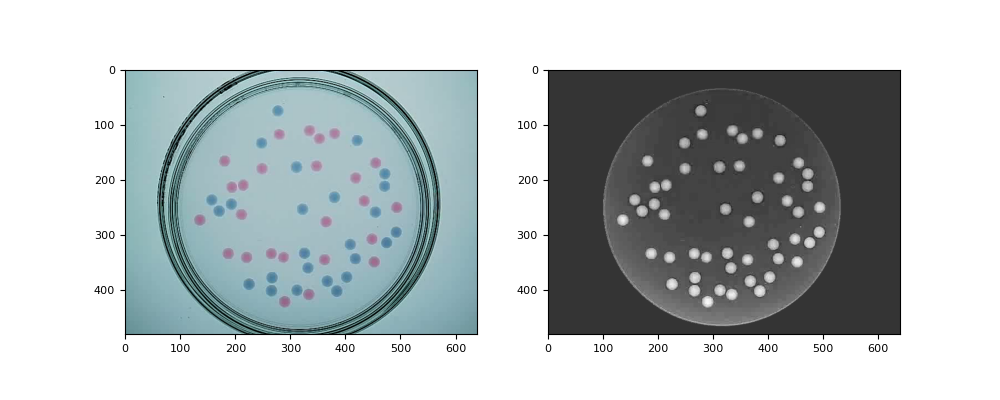

In [8]:
ref = pims.open('./data/25r25b-1.mp4')
print(ref)
data = preprocessing(ref, 480, 640, 100, 35, 530, 465) #895, 910)
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4))
ax.imshow(ref[0], cmap='gray')
ax1.imshow(data[0], cmap='gray')
plt.show()

In [9]:
path = './stardist_res/results_25_25/'
correct_n = 50

In [20]:
def get_data(frame):
    with h5py.File('/Volumes/ExtremeSSD/data.h5', 'r') as f:
        # Access the dataset within the HDF5 file
        dataset = f['dataset_name']
        example = dataset[frame]
    return example

In [12]:
if 0:
    nFrames = 1000
    framesList = np.arange(0, nFrames, 1)
    preprocessed_data = np.zeros((nFrames, data[0].shape[0], data[0].shape[1]), dtype=data[0].dtype)
    for i in tqdm(range(nFrames)):
        preprocessed_data[i] = data[i]
    # don't ! np.savez_compressed(path + 'preprocessed_data.npz', data=preprocessed_data) # --> 15 min
else:
    # Open the HDF5 file in read mode
    with h5py.File('/Volumes/ExtremeSSD/data.h5', 'r') as f:
        # Access the dataset within the HDF5 file
        dataset = f['dataset_name']
        example = dataset[-1]
    #preprocessed_data = np.load(path + 'preload.npz')['data'] # --> 3 min

In [13]:
example

array([[65, 65, 65, ..., 65, 65, 65],
       [65, 65, 65, ..., 65, 65, 65],
       [65, 65, 65, ..., 65, 65, 65],
       ...,
       [65, 65, 65, ..., 65, 65, 65],
       [65, 65, 65, ..., 65, 65, 65],
       [65, 65, 65, ..., 65, 65, 65]], dtype=uint8)

In [ ]:
## TEST
if 0:
    droplets_found = []
    area = []
    frames_sample = np.random.choice(np.arange(0, preprocessed_data.shape[0], 1), 100, replace=False)

    for frame in tqdm(frames_sample):
        img = preprocessed_data[frame]
        labels_test, dict_test = model.predict_instances(normalize(img), predict_kwargs = {'verbose':False}) 
        droplets_found.append(dict_test['coord'].shape[0])
        test = skimage.measure.regionprops_table(labels_test, properties=('centroid', 'area'))
        area += list(test['area'])
        """
        plt.figure(figsize = (10, 5))
        coord, points, prob = dict_test['coord'], dict_test['points'], dict_test['prob']
        ax = plt.subplot(121)
        ax.imshow(img, cmap='gray'); #plt.axis('off')
        ax.set(title = 'Preprocessed Image', xlabel='x', ylabel='y')
        ax1 = plt.subplot(122, sharex=ax, sharey=ax)
        ax1.imshow(img, cmap='gray'); #plt.axis('off')
        _draw_polygons(coord, points, prob, show_dist=True)
        ax1.set(title = f"Stardist result - {dict_test['coord'].shape[0]} droplets found", xlabel='x', ylabel='y')
        #ax.set(xlim=(200, 600), ylim=(200, 600))
        plt.tight_layout()
        plt.savefig(path + f'sample/stardist_test_{frame}.png', bbox_inches='tight', dpi = 500)
        plt.close()
        """
        
print(droplets_found)
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(np.sqrt(area)/np.sqrt(np.pi))
plt.show()

In [14]:
run = False
if run:
    ## SEGMENT ALL FRAMES AND SAVE THEM IN A NPZ FILE, COMPUTE THE FEATURES AND SAVE THEM IN A DATAFRAME
    segm_preload = np.zeros((len(framesList), data[0].shape[0], data[0].shape[1]), dtype=np.int8)
    area, x, y, prob, frames = [], [], [], [], []

    for ind, frame in tqdm(enumerate(framesList)):
        segm_preload[ind], dict_test = model.predict_instances(normalize(preprocessed_data[ind]), predict_kwargs = {'verbose':False})
        test = skimage.measure.regionprops_table(segm_preload[ind], properties=('centroid', 'area'))
        area += list(test['area'])
        y += list(test['centroid-0'])
        x += list(test['centroid-1'])
        prob += list(dict_test['prob'])
        frames += list(np.ones(len(list(test['centroid-0'])))*frame)

    # save data
    print("Saving data...")
    np.savez_compressed(path + 'segm.npz', data=segm_preload)
    df = pd.DataFrame({'x':x, 'y':y, 'area':area, 'prob':prob, 'frame':frames})
    df['frame'] = df.frame.astype('int')
    df['r'] = np.sqrt(df.area/np.pi)
    df.sort_values(by=['frame', 'prob'], ascending=[True, False], inplace=True)
    df.to_parquet(path + 'df.parquet')
else:
    #labeled_elements = np.load(path + 'segm.npz')['data'] #'data'
    df = pd.read_parquet(path + 'df.parquet')

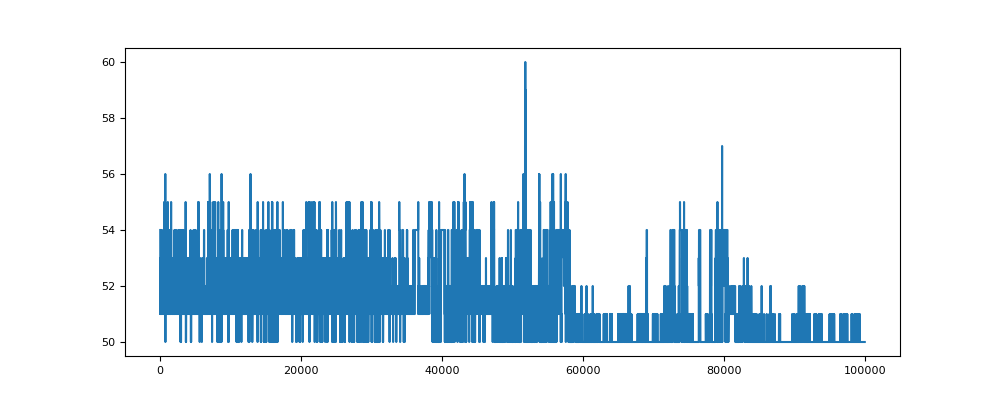

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(df.frame.unique(), df.groupby('frame').count().x.values)
#ax.axhline(correct_n, color='r')
plt.show()

frames: 100000


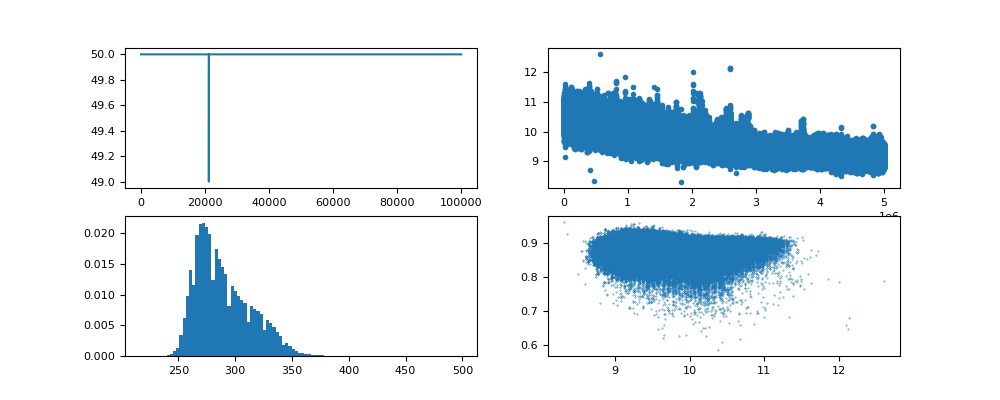

In [16]:
df = df.loc[df.r.between(8.3, 13)]
df = df.groupby('frame').apply(lambda x: x.nlargest(correct_n, 'prob'))
df = df.reset_index(drop=True)
print("frames:", len(df.frame.unique()))
fig, ax = plt.subplots(2, 2, figsize=(10, 4))
ax[0, 0].plot(df.frame.unique(), df.groupby('frame').count().x.values)
ax[0, 1].plot(df.r, '.')
ax[1, 0].hist(df.area, bins=100, density=True)
ax[1, 1].scatter(df.r, df.prob, s=0.1)
plt.show()

1 [21183]


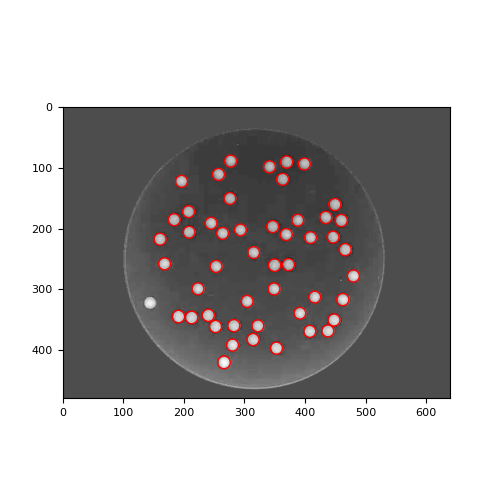

In [23]:
err_frames = np.where(df.groupby('frame').count().x != correct_n)[0] + df.frame.min()
print(len(err_frames), err_frames)
get_data(err_frames[-1])
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(get_data(err_frames[-1]), cmap='gray')
for i in range(len(df.loc[df.frame == err_frames[-1]])):
    ax.add_artist(plt.Circle((df.loc[df.frame == err_frames[-1]].x.values[i], df.loc[df.frame == err_frames[-1]].y.values[i]), df.loc[df.frame == err_frames[-1]].r.values[i], color='r', fill=False))
plt.show()

[ 8227 18675 18676 22323 22324 22325 22326 36635]


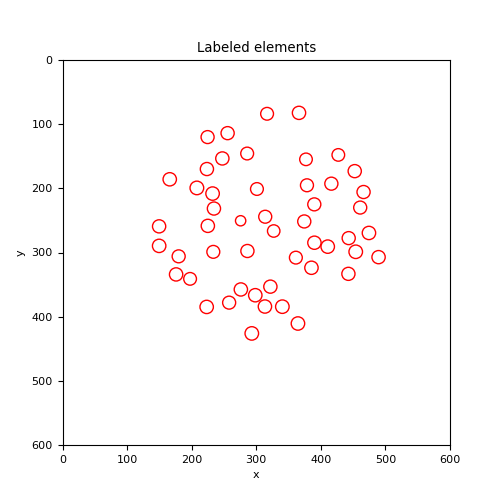

In [21]:
mmmeh_frames = df.loc[df.r < 8].frame.unique()
print(mmmeh_frames)
frame = mmmeh_frames[0]
df_plot = df.loc[df.frame == frame]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
#ax.imshow(preprocessed_data[frame - df.frame.min()])
for i in range(len(df_plot)):
    ax.add_artist(plt.Circle((df_plot.x.values[i], df_plot.y.values[i]), df_plot.r.values[i], color='r', fill=False))
ax.set(title='Labeled elements', xlabel='x', ylabel='y', xlim=(0, 600), ylim=(600, 0))
plt.show()

In [63]:
#############################################################################################################
#                                         LINK FEATURES WITH TRACKPY                                        #
#############################################################################################################
if 1:
    t = tp.link_df(df, 150, memory = 5, link_strategy = 'hybrid', neighbor_strategy = 'KDTree', adaptive_stop = 1)
    #print(t)
    t = t.sort_values(['frame', 'particle'])

    # CREATE COLOR COLUMN AND SAVE DF
    n = max(t.particle)
    print(n)
    random.seed(5)
    colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(n)]
    for i in range(max(t.particle)+1-n):
        colors.append("#00FFFF")
    c = []
    for p in t.particle:
        c.append(colors[p])
    t["color"] = c
    # filter out trajectories that are too short
    t = tp.filter_stubs(t, 25)

    # TODO -- interpolate gaps in trajectories

    trajectory = t.copy()
    print(trajectory)
    trajectory.to_parquet(path + 'df_linked.parquet')
    
else:
    trajectory = pd.read_parquet(path + 'df_linked.parquet')
    print(trajectory)

50
                  x           y  area      prob  frame          r  particle   
0        170.163435  256.675900   361  0.903722      0  10.719602         0  \
27       157.009288  236.529412   323  0.882320      0  10.139728         1   
28       352.070988  125.811728   324  0.881527      0  10.155413         2   
29       247.380952  133.747024   336  0.881081      0  10.341766         3   
30       311.434402  400.303207   343  0.880936      0  10.448937         4   
...             ...         ...   ...       ...    ...        ...       ...   
1499944  230.172881  104.372881   295  0.899357  29999   9.690274        45   
1499958  453.614618  334.292359   301  0.889817  29999   9.788323        46   
1499963  334.712871  386.910891   303  0.886420  29999   9.820789        47   
1499953  277.483871  401.390323   310  0.891228  29999   9.933583        48   
1499982  224.017483  164.783217   286  0.866205  29999   9.541312        49   

           color  
0        #8B0E71  
27       #

8236


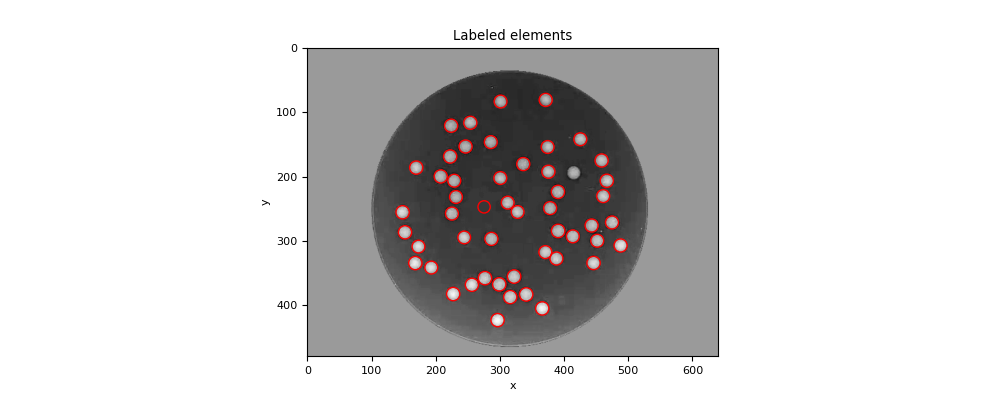

In [67]:
a = trajectory.loc[trajectory.particle == max(trajectory.particle)].frame.unique()[0]
print(a)
df_plot = trajectory.loc[trajectory.frame == a]

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.imshow(preprocessed_data[a])
for i in range(len(df_plot)):
    ax.add_artist(plt.Circle((df_plot.x.values[i], df_plot.y.values[i]), df_plot.r.values[i], color='r', fill=False))
ax.set(title='Labeled elements', xlabel='x', ylabel='y')
ax1.set(title='Preprocessed image', xlabel='x', ylabel='y')
plt.show()

KeyboardInterrupt: 

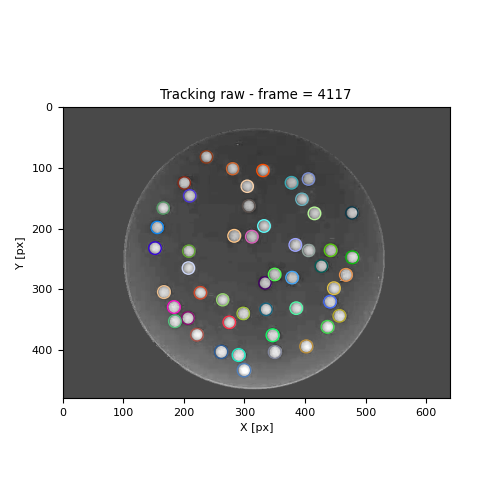

In [72]:
fig = plt.figure(figsize = (5, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(frame):
    df = trajectory.loc[(trajectory.frame == frame) , ["x", "y", "color", "r"]]
    for i in range(len(df)):
        graph[i].center = (df.x.values[i], df.y.values[i])
        graph[i].radius = df.r.values[i]
    graph2.set_data(preprocessed_data[frame-trajectory.frame.min()])
    title.set_text('Tracking raw - frame = {}'.format(frame))
    return graph

ax = fig.add_subplot(111)
title = ax.set_title('Tracking stardist + trackpy - frame = 0')
ax.set(xlabel = 'X [px]', ylabel = 'Y [px]')
df = trajectory.loc[(trajectory.frame == trajectory.frame.min()), ["x", "y", "color", "r"]]

graph = []
for i in range(len(df)):
    graph.append(ax.add_artist(plt.Circle((df.x.values[i], df.y.values[i]), df.r.values[i], color = df.color.values[i],\
                                           fill = False, linewidth=1)))
graph2 = ax.imshow(preprocessed_data[0])

fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, range(trajectory.frame.min(), trajectory.frame.max(), 1), interval = 5, blit=False)
if 1: 
    writer = matplotlib.animation.FFMpegWriter(fps = 30, metadata = dict(artist='Matteo Scandola'), extra_args=['-vcodec', 'libx264'])
    ani.save(path + 'tracking.mp4', writer=writer, dpi = 300)
plt.close()